# SIT796 - Task 3.1D - Exact Policy Iteration

In [1]:
!pip install gym==0.12.5

### Installing dependencies

In [1]:
import gym
import numpy as np
import sys
import copy
from six import StringIO, b
from gym.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt
from mdp import MDP
from mdp import has_graphviz
import plot_utils
from mdp import MDP
from mdp import has_graphviz
from IPython.display import display
import graphviz
from collections import defaultdict

In [2]:
print("Graphviz available:", has_graphviz)

Graphviz available: True


## Instantiating Frozen Lake Environment

FrozenLake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H). The lake has a slippery nature, hence an agent may not always move to the right direction. It's an 8x8 grid world environment.
The state space of the enviroment is the following

"8x8": 
```
[
    "SFFFFFFF",
    "FFFFFFFF",
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFHFFFG",
]
```

The agent moves through a $8 \times 8$ gridworld, with states numbered as follows:
```
[[ 0  1   2   3   4   5   6  7]
 [ 8  9  10  11  12  13  14 15]
 [ 16 17 18  19  20  21  22 23]
 [ 24 25 26  27  28  29  30 31]
 [ 32 33 34  35  36  37  38 39]
 [ 40 41 42  43  44  45  46 47]
 [ 48 49 50  51  52  53  54 55]
 [ 56 57 58  59  60  61  62 63]
]
```
and the agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

I am using dynamic programming to solve the MDP, and in this sceario I am assuming that the agent has full knowledge of the environment.

I am using is_slippery= True, hence `env.P` is providing the conditional probability of the next state and rewards, from one particular state.

In [4]:
frozen_lake_env = gym.make('FrozenLake-v0', desc=None,map_name="8x8", is_slippery=True)

### Exploring the State and Action space of Frozen Lake Environment

In [5]:
print("Printing the state/observation space matrix : ", frozen_lake_env.observation_space)
print("Printing the action space matrix : ", frozen_lake_env.action_space)

Printing the state/observation space matrix :  Discrete(64)
Printing the action space matrix :  Discrete(4)


### Displaying the Transition Probability of State = 0 and Action = 2

In [6]:
print(frozen_lake_env.P[0][2])

[(0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]


In [7]:
print("Printing the state space of FrozenLake", frozen_lake_env.nS)
print("Printing the action space of FrozenLake", frozen_lake_env.nA)

Printing the state space of FrozenLake 64
Printing the action space of FrozenLake 4


In [8]:
frozen_lake_env.action_space.n

4

## Displaying MDP

In [9]:
from mdp import MDP
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


# Generating Transition Probs and Rewards

- Generating the transition probabilities arrays for using in the Policy Iteration algorithm <br>



- Genearting transition probabilities and rewards dict for the visualization of the FrozenLake MDP by extracting the environment trasition probabilities and aligning the structure of the trasition probabilities and rewards for the MDP Visualization.

In [10]:
def extract_transition_item(t_matrix, state, action, state_action_value):
    for transition_item in state_action_value:
        prob_idx = transition_item[1]
        t_matrix[state][prob_idx][action] += transition_item[0] 
        mdp_reward_item = {"s"+str(state): {"a"+str(action): {transition_item[1]: transition_item[2]}}}
    return t_matrix, mdp_reward_item

In [11]:
def extract_transition_prob(env):
    environment = env.P
    T = np.zeros((env.nS, env.nS, 4), dtype = float)
    
    left = np.zeros(env.nS, dtype = float)
    down = np.zeros(env.nS, dtype = float)
    right = np.zeros(env.nS, dtype = float)
    up = np.zeros(env.nS, dtype = float)
    
    rewards = []
    
    for state in range(env.nS):
        state_dict = environment[state]
        for key, state_action_value in state_dict.items():
            if key == 0:
                T, r = extract_transition_item(T, state, key, state_action_value)
                rewards.append(r)
            if key == 1:
                T, r = extract_transition_item(T, state, key, state_action_value)
                rewards.append(r)
            if key == 2:
                T, r = extract_transition_item(T, state, key, state_action_value)
                rewards.append(r)
            if key == 3:
                T, r = extract_transition_item(T, state, key, state_action_value)
                rewards.append(r)

    return T, rewards

In [12]:
transition_prob_matrix, reward_val = extract_transition_prob(frozen_lake_env)

### Printing the Transition Probability matrix

In [13]:
reward_dict = {}
for r_idx in range(len(reward_val)):
    reward_item_dict = reward_val[r_idx]
    for key, value in reward_item_dict.items():
        reward_dict.update({key: value})
    

In [15]:
def generate_transition_probs(env):
    trans_dict = {}
    state_dict = {}
    for state_idx in range(env.nS):
        state = env.P[state_idx]
        
        state_dict = {"s"+str(state_idx):{}}
        action_dict = {}
        for key, value_list in state.items():
            transition_dict = {}
            action_dict = {"a"+str(key) : transition_dict}
            
            for item in value_list:
                if "s"+str(item[1]) in transition_dict:
                    transition_dict["s"+str(item[1])] += item[0]
                else:
                    transition_dict["s"+str(item[1])] = item[0]
            state_dict["s"+str(state_idx)] = action_dict
        trans_dict["s"+str(state_idx)] = action_dict
        
    return trans_dict

In [16]:
transition_dict = generate_transition_probs(frozen_lake_env)
print(transition_dict)

{'s0': {'a3': {'s1': 0.3333333333333333, 's0': 0.6666666666666666}}, 's1': {'a3': {'s2': 0.3333333333333333, 's1': 0.3333333333333333, 's0': 0.3333333333333333}}, 's2': {'a3': {'s3': 0.3333333333333333, 's2': 0.3333333333333333, 's1': 0.3333333333333333}}, 's3': {'a3': {'s4': 0.3333333333333333, 's3': 0.3333333333333333, 's2': 0.3333333333333333}}, 's4': {'a3': {'s5': 0.3333333333333333, 's4': 0.3333333333333333, 's3': 0.3333333333333333}}, 's5': {'a3': {'s6': 0.3333333333333333, 's5': 0.3333333333333333, 's4': 0.3333333333333333}}, 's6': {'a3': {'s7': 0.3333333333333333, 's6': 0.3333333333333333, 's5': 0.3333333333333333}}, 's7': {'a3': {'s7': 0.6666666666666666, 's6': 0.3333333333333333}}, 's8': {'a3': {'s9': 0.3333333333333333, 's0': 0.3333333333333333, 's8': 0.3333333333333333}}, 's9': {'a3': {'s10': 0.3333333333333333, 's1': 0.3333333333333333, 's8': 0.3333333333333333}}, 's10': {'a3': {'s11': 0.3333333333333333, 's2': 0.3333333333333333, 's9': 0.3333333333333333}}, 's11': {'a3': 

In [17]:
from mdp import MDP
mdp = MDP(transition_dict, reward_dict, initial_state='s0')

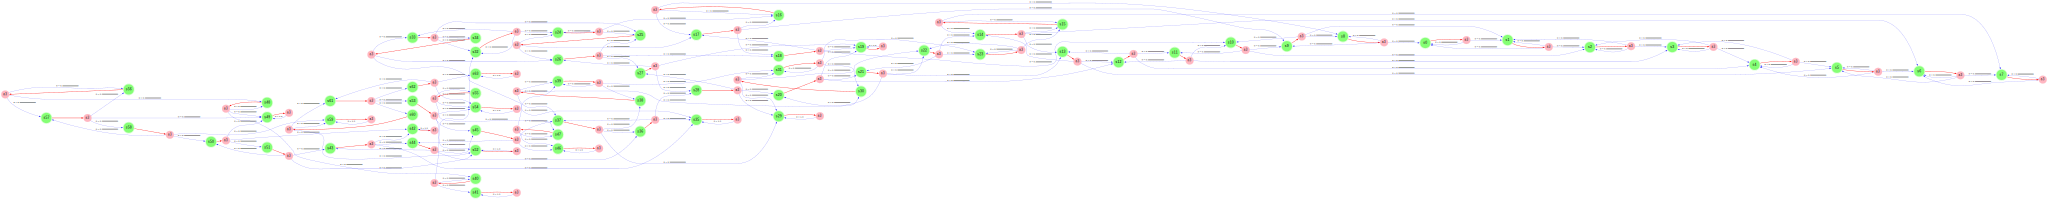

In [18]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    gr = plot_graph(mdp)
    gr.render(filename='g1.dot')
    display(gr)

## Policy Evaluation

In MDP, the primary objective is to obtain near optimal policies. In the policy iteration function we are calculating the value of a policy which will be improved later in order to yield an even better $\large{\pi}'$ We use the Bellman equation in order to find $\large{v_\pi}(s)$ which is the expected discounted cumulative reward starting in state $s$ and following policy $\large{\pi}$

In [39]:
def policy_evaluation(env, policy, utility, T, reward, gamma):
    for state in range(env.nS):
        action = int(policy[state])
        utility[state] = np.linalg.solve(np.identity(env.nS) - gamma*T[:,:,action], reward)[state]          
    return utility

In [40]:
def policy_refinement(env, T, policy, utility):
    for state in range(env.nS):
        cur_state_vector = np.zeros((1, env.nS))
        cur_state_vector[0,state] = 1.0
        action_values = np.zeros(env.action_space.n)
        for action in range(env.action_space.n):
            action_values[action] = np.sum(np.multiply(utility, np.dot(cur_state_vector, T[:,:,action])))
        expected_action = np.argmax(action_values)
        policy[state] = expected_action
    return policy

## Policy Iteration

In [42]:
def policy_iteration(env, discount_factor):
    epsilon = 39.8
    policy = np.random.randint(0, env.nA, env.nS)
    
    utility = np.zeros(env.nS)
    rewards = np.zeros(env.nS)
    rewards[-1] = 1.0
    
    iteration = 0
    
    while True:
        iteration += 1
        utility_prev = utility.copy()
        utility = policy_evaluation(env, policy, utility, transition_prob_matrix, rewards, discount_factor)
        delta = np.absolute(utility - utility_prev).max()
        policy = policy_refinement(env, transition_prob_matrix, policy, utility)  
        if delta < epsilon:
            break 
        print(iteration, delta)
            
    return utility, policy

In [43]:
optimal_value, optimal_policy = policy_iteration(frozen_lake_env, discount_factor = 0.99)

1 99.99999999999991
2 61.49341322176643
3 55.41787832613286
4 52.29508787377714
5 50.75699705396015
6 49.98353555864598
7 50.60832262642946
8 46.40177682399662
9 42.550439692173214


In [44]:
print('Optimal Value function: ')
print(optimal_value)

Optimal Value function: 
[-3.19629031e-29 -3.29314759e-29  0.00000000e+00  8.23574039e-01
  3.97197910e+01  4.51897313e+01  4.99667046e+01  5.07569971e+01
 -3.19535091e-29 -3.29124032e-29  0.00000000e+00  5.03689201e-01
  3.54534807e+01  4.17821437e+01  5.06905547e+01  5.22950879e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.78253165e-45
  2.59328553e+01 -3.00484602e-30  5.13459492e+01  5.54178783e+01
 -0.00000000e+00  0.00000000e+00  1.25496305e-01  3.30840339e-01
 -8.26466148e-31  1.87806595e-14  4.94853523e+01  6.02199984e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.53355530e-30
  1.16388378e+01  9.98362616e-14  7.30634077e-14  6.68469670e+01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  7.14440198e-01
  2.19194456e-14  4.60458161e-15  4.24440021e-14  7.54996012e+01
  0.00000000e+00 -0.00000000e+00  5.01426782e-15 -3.16710599e-31
  3.59298620e-32  1.51419952e-16  3.43006637e-33  8.64401021e+01
  0.00000000e+00 -0.00000000e+00 -6.34289139e-15 -1.91413427e-32


In [45]:
print('Optimal Policy function: ')
print(optimal_policy)

Optimal Policy function: 
[0 1 1 2 2 2 2 2 0 1 1 2 2 3 2 2 1 1 0 0 0 3 2 2 0 1 1 0 0 0 2 2 0 0 0 0 1
 3 3 2 0 0 0 1 3 3 0 2 0 0 3 0 0 0 0 2 0 0 3 0 1 1 1 0]


In [46]:
optimal_policy

array([0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 3, 2, 2, 1, 1, 0, 0, 0, 3,
       2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 3, 3, 2, 0, 0, 0, 1,
       3, 3, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 3, 0, 1, 1, 1, 0])

In [52]:
np.save("fl_8x8_optimal_policy_final", optimal_policy)

## Testing Optimal Policy on Frozen Lake environment

In [47]:
def test_optimal_policy(env, n_iters, policy, random = False):
    iter_rewards = []
    cumulative_reward = 0
    for n in range(n_iters):
        stop_episode = False
        state = env.reset() 
        while not stop_episode:        
            action = policy[state]
            next_state, reward, stop_episode, info = env.step(action)
            cumulative_reward += reward
            state = next_state
            iter_rewards.append((n, cumulative_reward))
                
    avg_reward = cumulative_reward / n_iters
    return cumulative_reward, avg_reward, iter_rewards


In [53]:
fl_8x8_optimal_policy_final = np.load("fl_8x8_optimal_policy_final.npy")

In [48]:
iterations = 1000
cumulative, avg, episodic = test_optimal_policy(frozen_lake_env, iterations, fl_8x8_optimal_policy_final)

In [49]:
avg

0.021

In [50]:
cumulative

21.0

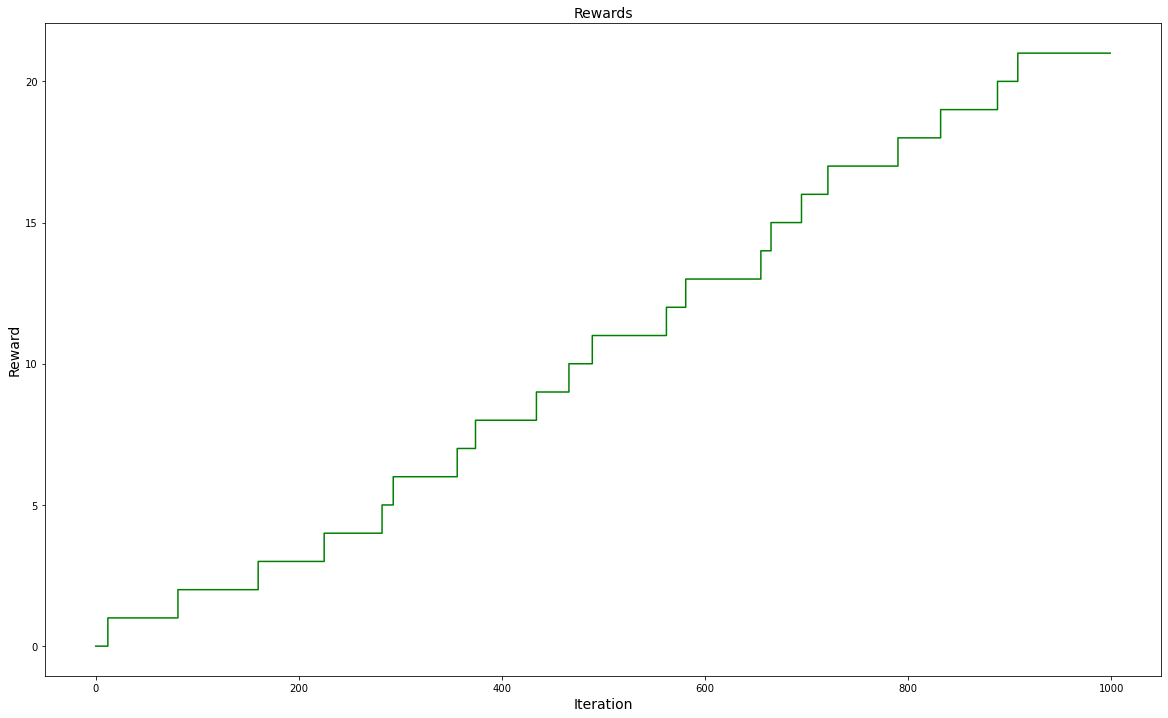

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.plot([x for x, y in episodic], [y for x, y in episodic],color='green')
plt.title('Rewards', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid(False)
plt.show()